In [1]:
try :
    %tensorflow_version 2.x
except Exception : 
    pass

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler


import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
print(tf.__version__)

2.1.0


In [3]:
df = pd.read_csv('original_full_data.csv', index_col = 0)

In [4]:
mmdf = pd.read_csv('bloomberg_map_index_20200130.csv', index_col = 0)

In [5]:
df.head()

,date,GDPCQOQIndex,GDPCYOYIndex,GDPCTOT%Index,GPDITOC%Index,GPGSTOC%Index,RGCDCIPIIndex,GDPCUR$Index,GDPCURYIndex,GDPPIQQIndex,...,g16,g32,g64,g128,avg,avg_four,ssd_price,flash_price,option_bit,future_bit
0,1981-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1981-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1981-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1981-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1981-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df = df.loc[9132 :, :]

In [7]:
len(df)

5051

In [8]:
df.reset_index(inplace = True, drop = True)

In [9]:
# Class generates derived variables & shifting target variable

class Builder:

    def __init__(self, input_df, map_df, target_day):
        self.df = input_df
        self.mdf = map_df
        self.lag_days = [1, 5, 20, 60, 120, 260] # lagging day variation [1day 1week 1month 3month 6month 1year]
        self.target_day = target_day # ex) 1, 260


    # shifting function

    def targeter(self, target_column):
        self.df[target_column] = self.df[target_column].shift(-1*int(self.target_day))

        return self.df
    
    # generating derived columns function : return ex) 20060107/20060101

    def returner(self, target_column):      

        col_name =  []
        # creating new column name
        for i in self.lag_days:
            col_name.append(target_column + str(i))
            
        # appending lagged columns
        for i, j in enumerate(self.lag_days):
            self.df[locals()['col_name'][i]] = self.df[target_column] / self.df[target_column].shift(periods = j, axis = 0)

        return self.df 

    # generating derived function : minus ex) 20060107 - 20060101
    
    def differ(self, target_column):

        col_name = []
        for i in self.lag_days:
            col_name.append(target_column + str(i))
        for i, j in enumerate(self.lag_days):
            self.df[locals()['col_name'][i]] = self.df[target_column] - self.df[target_column].shift(periods = j, axis = 0)
        return self.df

    # generating derived function : volume * close  -> convert to return 

    def producter(self, target_column):

        col_name = (str(target_column).split('_'))[0]       
        self.df[locals()['col_name'] + '_product'] = self.df[col_name + '_volume'] * self.df[col_name + '_close'] # j volume과 j close를 곱해서 

        return self.df
    
    # executing functions
    
    def execution(self):
        for i, j in enumerate(self.mdf['ticker']): # mdf에서 ticker 확인
            if j in self.df.columns:
                if self.mdf.loc[i, :][1] == 'product':  # key값이 product인 경우
                    self.producter(j)
                    col = str(j).split('_')[0]
                    self.df[col + '_product'] = self.df[col + '_product'] / self.df[col + '_product'].shift(1)
                    
                elif self.mdf.loc[i, :][1] == 'minus': # key값이 minus인 경우
                    self.differ(j)

                elif self.mdf.loc[i, :][1] == 'change': # key값이 change인 경우
                    self.returner(j)


                elif self.mdf.loc[i, :][1] == 'target': # key값이 target인 경우 (현재 KRXsemiconductor_change)
                    self.targeter(j)

                else:
                    pass
            else:
                pass
                            
        return self.df


    # side : creating auto correlation graph function

    def acf_cal(self, target):
        data = pd.DataFrame(self.df[target])
        data = data.interpolate(method = 'cubic', limit_area = 'inside').fillna(method = 'ffill').fillna(method = 'bfill')
        acf = sm.tsa.acf(data)      
        plt.stem(acf)
        plt.show()

In [10]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace = True)

In [11]:
# fillna cubic -> ffill -> bfill

df = df.interpolate(method = 'cubic', limit_area = 'inside')
df = df.fillna(method = 'ffill')
df = df.fillna(method = 'bfill')

In [12]:
df.isna().sum().sum()

0

In [13]:
cla = Builder(df, mmdf, 1)

In [14]:
cla.execution()

,GDPCQOQIndex,GDPCYOYIndex,GDPCTOT%Index,GPDITOC%Index,GPGSTOC%Index,RGCDCIPIIndex,GDPCUR$Index,GDPCURYIndex,GDPPIQQIndex,GDPCPCECIndex,...,Philadelphia_product,QCOM_product,SamsungElectronics_product,ShinEtsuChemical_product,Siltronic_product,SKhynix_product,Sumco_product,TokyoElectron_product,TSMC_product,UMC_product
date,,,,,,,,,,,,,,,,,,,,,
2006-01-02,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,1.000000,1.000000,0.862009,1.000000,1.000000,1.048766,1.000000,1.000000,1.000000,1.000000
2006-01-04,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,0.967923,1.097724,2.307115,1.000000,1.000000,1.549763,1.000000,1.000000,0.788606,0.581332
2006-01-05,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,1.168471,0.642743,0.878133,1.000000,1.000000,0.913503,1.000000,4.149537,0.835657,2.780952
2006-01-06,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,1.047620,2.572150,0.504080,1.000000,1.000000,0.596882,1.000000,1.117321,1.553101,1.545230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-27,1.9,2.0,2.9,-1.5,2.0,69.0,21525.82,3.7,1.7,2.2,...,0.954025,1.223596,-7.016632,1.443049,0.882592,0.724875,0.591650,1.185079,0.728242,8.957344
2019-10-28,1.9,2.0,2.9,-1.5,2.0,69.0,21525.82,3.7,1.7,2.2,...,0.988696,0.869484,3.268112,0.911087,0.984864,0.598464,0.436636,1.103782,1.596400,-4.887075
2019-10-29,1.9,2.0,2.9,-1.5,2.0,69.0,21525.82,3.7,1.7,2.2,...,1.023202,0.493114,1.174228,0.410159,1.089446,0.832789,1.231150,1.131356,1.864625,2.523049


In [15]:
df = cla.df.fillna(method = 'ffill').fillna(method = 'bfill')

In [16]:
df.reset_index(inplace = True)

In [17]:
TRAIN_SPLIT = 3000 # 3000부터 대강 쪼개면 될듯

In [18]:
tf.random.set_seed(13)

In [19]:
def create_time_steps(length): # 이전 len 5 4 3 2 1 이렇게 스텝 생성하는 function
    return list(range(-length, 0))

In [20]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']

    time_steps = create_time_steps(plot_data[0].shape[0]) # 들어가는 plot_data 는 x_train_uni , 20개 하고 label y_train_uni 하나니까 그래프가 저렇게 

    if delta: # delta는 y_train 
        future = delta # 확인 결과 True난 1이거나 값이 있으면 실행 False, 0 , None인 경우 미 실행 delta가 값이 있으면 그걸로 받는것이다 (1이상))
    else :
        future = 0



    plt.title(title) # 이건 걍 title
    for i, x in enumerate(plot_data): # plot data 순회 -> 마지막 깨달음 아 시박 x y가 둘 다 들어갔으니 당연히 0, 1이지 시발

        if i: # 0이면 ? plot_data [0] 에 대해서만 이 그림을 그리고 처음에 밑그림을 그릴 필요가 있어서 이렇게 짠거인듯. 0 False None 빼고 다 출력
                        
            plt.plot(future, plot_data[i], marker[i], markersize = 5, # else를 보고 이걸 보면.. 처음에 전체 데이터를 가지고 그림을 그린 다음 그냥 마지막 것만 실행하며 덧씌우고
                     # future를 가지고 True Future 점을 하나 찍는 형태가 된거임. 
                     label = labels[i]) # label 의 1이 적용이 된건데? marker의 1이 적용이 되고, plot
            
        else: # 0 False None 인경우 인듯. 0인 경우 그림을 그림 time_steps plot_data[i] (x_train_uni0길이만큼 정수 : 0 ~ 20) flatten을 하는 이유는 그냥 한줄로 넣으려고. np는그게도나봄. 
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i]) # label도 label의 0~ 20번째 근데 라벨값은 하나아냐?  아 0이니까. 
    # 점을 찍었다면 x축은 어디가 되는건가? 아 알겠군 -> time step이 필요했던건 real값과 prediction값을 다른 선상에 두기 위해서였다. 
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')

    return plt

In [21]:
features_considered = ['SKhynix_change', 'Philadelphia_change', 'Micron_change', 'MediaTek_change', 'USDollarIndex_close', 'FRNTTNETIndex', 'Intel_product', 'USD_KRW_change', 'CPUPXCHGIndex', 'KOBONTLIndex', 'RSTAMOMIndex', 'KOEXPTIYIndex', 'KOCPIMOMIndex', 'Dell_close', 'Dell_volume', 'GPGSTOC%Index', 'SKLIOTARIndex', 'Nvidia_volume', 'SKCIMOMIndex', 'KOCGCGYIndex', 'KOECPRCYIndex', 'LEIBPIndex', 'AMD_change', 'JOLTSEPSIndex', 'HPE_close', 'Sumco_change', 'KOGFBALIndex', 'CNFREXPYIndex', 'TokyoElectron_close', 'EUR_KRW_close', 'KOBPFINIndex', 'Amazon_change', 'UMC_product', 'KOECGVTYIndex', 'KOBPCAIndex', 'KOECIMPYIndex', 'NAPMNMIIndex', 'USWHTOTIndex', 'Amazon_volume', 'KOECFCSYIndex', 'Google_product', 'KOFDITYIndex', 'KOQEEYOYIndex', 'TokyoElectron_volume', 'CNGDPYOYIndex', 'MBRXYOYWIndex', 'ShinEtsuChemical_volume', 'USTBEXPYIndex', 'AppliedMaterials_product', 'QCOM_product', 'SKhynix_product', 'UMC_volume', 'APPLE_product', 'KOECSIMQIndex', 'SKLICPYIndex', 'SKLICONEIndex', 'LEIMNOIndex', 'SAARDTOTIndex', 'KOBPCBIndex', 'USHEYOYIndex', 'USEMNCHGIndex', 'MGT2MAIndex', 'KOPPIMOMIndex', 'KOIVCONYIndex', 'Intel_volume', 'g16', 'AMD_product', 'KOEXTOTIndex', 'KOFETOTIndex', 'SKLINBARIndex', 'ssd_price', 'SKLILAPIndex', 'KOCPIIndex', 'TSMC_product', 'KOPPIYOYIndex', 'Philadelphia_volume', 'APPLE_volume', 'RSTAYOYIndex', 'Micron_product', 'Micron_volume', 'PITLCHNGIndex', 'SAARTOTLIndex', 'EUR_KRW_volume', 'JPY_KRW_volume', 'USDollarIndex_volume', 'USD_KRW_volume', 'TokyoElectron_change', 'Intel_change', 'KOWDRIndex', 'Nvidia_product', 'ShinEtsuChemical_close', 'memory_price', 'NFPTCHIndex', 'NFPPCHIndex', 'KOGDPYOYIndex', 'KOEAEPRIndex', 'USGG3MIndex', 'SKLILAIIndex']

In [22]:
target_considered = ['KRXsemiconductor_change']

In [23]:
targets = df[target_considered]

In [24]:
features = df[features_considered]

In [25]:
features.index = df['date']
targets.index = df['date']

In [26]:
features.head()

,SKhynix_change,Philadelphia_change,Micron_change,MediaTek_change,USDollarIndex_close,FRNTTNETIndex,Intel_product,USD_KRW_change,CPUPXCHGIndex,KOBONTLIndex,...,KOWDRIndex,Nvidia_product,ShinEtsuChemical_close,memory_price,NFPTCHIndex,NFPPCHIndex,KOGDPYOYIndex,KOEAEPRIndex,USGG3MIndex,SKLILAIIndex
date,,,,,,,,,,,,,,,,,,,,,
2006-01-02,6.52,2.845,1.50,5.21,89.84,232.248,1.000000,0.53,0.2,11299.0,...,20.5,1.000000,10.19,0.112212,278.0,310.0,6.4,58.5,4.0736,2640.2
2006-01-03,1.33,2.845,1.50,5.21,89.84,232.248,1.000000,-0.82,0.2,11299.0,...,20.5,1.000000,10.19,0.112212,278.0,310.0,6.4,58.5,4.1144,2640.2
2006-01-04,-7.35,0.722,4.00,5.21,89.14,232.248,0.829714,-0.61,0.2,11299.0,...,20.5,1.109161,10.19,0.112212,278.0,310.0,6.4,58.5,4.1798,2640.2
2006-01-05,-1.98,2.386,0.93,5.21,89.33,232.248,1.204864,-0.36,0.2,11299.0,...,20.5,1.294707,10.19,0.112212,278.0,310.0,6.4,58.5,4.1793,2640.2
2006-01-06,1.30,2.169,2.05,5.21,88.85,232.248,0.833842,-0.55,0.2,11299.0,...,20.5,0.980556,10.19,0.112212,278.0,310.0,6.4,58.5,4.1985,2640.2


In [27]:
targets.head()

,KRXsemiconductor_change
date,
2006-01-02,0.33
2006-01-03,0.33
2006-01-04,0.33
2006-01-05,0.33
2006-01-06,0.33


In [28]:
#features.plot(subplots = True)

In [29]:
col_name = features.columns

In [30]:
dataset = StandardScaler().fit_transform(features)

In [31]:
dataset = pd.DataFrame(dataset, columns = col_name)

In [32]:
dataset.head()

,SKhynix_change,Philadelphia_change,Micron_change,MediaTek_change,USDollarIndex_close,FRNTTNETIndex,Intel_product,USD_KRW_change,CPUPXCHGIndex,KOBONTLIndex,...,KOWDRIndex,Nvidia_product,ShinEtsuChemical_close,memory_price,NFPTCHIndex,NFPPCHIndex,KOGDPYOYIndex,KOEAEPRIndex,USGG3MIndex,SKLILAIIndex
0,1.872605,1.352064,0.393993,0.818091,0.451945,2.554807,-0.070772,0.643714,0.561804,-2.370039,...,-0.012545,-0.018857,-1.060391,3.944198,0.768354,0.948862,1.522337,-1.317607,1.793907,-1.481244
1,0.360736,1.352064,0.393993,0.818091,0.451945,2.554807,-0.070772,-1.001021,0.561804,-2.370039,...,-0.012545,-0.018857,-1.060391,3.944198,0.768354,0.948862,1.522337,-1.317607,1.819072,-1.481244
2,-2.167786,0.344170,1.021054,0.818091,0.366335,2.554807,-0.263632,-0.745173,0.561804,-2.370039,...,-0.012545,0.056204,-1.060391,3.944198,0.768354,0.948862,1.522337,-1.317607,1.859409,-1.481244
3,-0.603481,1.134154,0.251023,0.818091,0.389572,2.554807,0.161250,-0.440593,0.561804,-2.370039,...,-0.012545,0.183789,-1.060391,3.944198,0.768354,0.948862,1.522337,-1.317607,1.859101,-1.481244
4,0.351997,1.031133,0.531947,0.818091,0.330868,2.554807,-0.258957,-0.672074,0.561804,-2.370039,...,-0.012545,-0.032227,-1.060391,3.944198,0.768354,0.948862,1.522337,-1.317607,1.870943,-1.481244


In [33]:
dataset = dataset.values

In [34]:
targets = targets.values

In [35]:
def multivariate_data(dataset, target, start_index, end_index, history_size, 
                      target_size, step, single_step = False):
    
    data = []
    labels = []

    start_index = start_index + history_size

    if end_index is None:
        end_index = len(dataset) - target_size

    
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        
        else:
            labels.append(target[i: i + target_size])

        return np.array(data), np.array(labels)


In [61]:
past_history = 720
future_target = 72
BATCH_SIZE = 256
BUFFER_SIZE = 10000

STEP = 6



In [62]:
x_train_single, y_train_single = multivariate_data(dataset, targets, 0, 
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step = True)

x_val_single, y_val_single = multivariate_data(dataset, targets,
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step = True)

In [63]:
print('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 98)


In [39]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [40]:
val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [41]:
# early stopping을 넣어보자
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 5)

In [42]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape = x_train_single.shape[-2:], return_sequences = True, activation = 'sigmoid'))
single_step_model.add(tf.compat.v2.keras.layers.Dropout(0.3))
single_step_model.add(tf.keras.layers.LSTM(32, return_sequences = True, activation = 'sigmoid'))
single_step_model.add(tf.compat.v2.keras.layers.Dropout(0.3))
single_step_model.add(tf.keras.layers.LSTM(16, activation = 'sigmoid'))
single_step_model.add(tf.keras.layers.Dense(1))

In [43]:
single_step_model.compile(optimizer = tf.keras.optimizers.Adam(),
                          loss = 'mse')

In [44]:
single_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 32)           16768     
_________________________________________________________________
dropout (Dropout)            (None, 120, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 120, 32)           8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 28,241
Trainable params: 28,241
Non-trainable params: 0
____________________________________________________

In [45]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(1, 1)


In [46]:
EVALUATION_INTERVAL = 200
EPOCHS = 30

In [53]:
single_step_history = single_step_model.fit(train_data_single, epochs = EPOCHS, callbacks = [earlystop_callback],
                                            steps_per_epoch = EVALUATION_INTERVAL,
                                            validation_data = val_data_single,
                                            validation_steps = 50)

Train for 200 steps, validate for 50 steps
Epoch 1/30
200/200 [==============================] - 25s 125ms/step - loss: 0.3321 - val_loss: 0.4820
Epoch 2/30
200/200 [==============================] - 21s 107ms/step - loss: 0.0087 - val_loss: 0.4121
Epoch 3/30
200/200 [==============================] - 22s 108ms/step - loss: 0.0059 - val_loss: 0.3897
Epoch 4/30
200/200 [==============================] - 22s 108ms/step - loss: 0.0056 - val_loss: 0.4319
Epoch 5/30
200/200 [==============================] - 21s 104ms/step - loss: 0.0043 - val_loss: 0.3765
Epoch 6/30
200/200 [==============================] - 21s 106ms/step - loss: 0.0038 - val_loss: 0.3680
Epoch 7/30
200/200 [==============================] - 21s 107ms/step - loss: 0.0023 - val_loss: 0.4140
Epoch 8/30
200/200 [==============================] - 22s 108ms/step - loss: 0.0014 - val_loss: 0.3659
Epoch 9/30
200/200 [==============================] - 21s 104ms/step - loss: 0.0012 - val_loss: 0.3624
Epoch 10/30
200/200 [=========

In [55]:
single_step_history

NameError: name 'single_step_history' is not defined

In [47]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label = 'Training loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation loss')

    plt.title(title)
    plt.legend()

    plt.show()

In [56]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

NameError: name 'val_univariate' is not defined

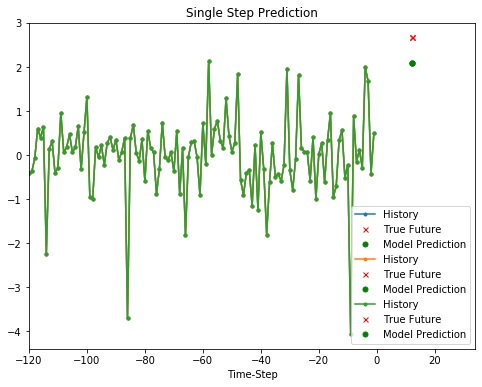

In [53]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(), single_step_model.predict(x)[0]], 12,
                      'Single Step Prediction')

In [63]:
single_step_model.save('ltsm_20200220.h5')

In [51]:
single_step_model = tf.keras.models.load_model('ltsm_20200220.h5')

In [60]:
# 그 다음은 multi step model로 해보자. 
# 이게 그 형태인듯. 

In [65]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [66]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 98)

 Target temperature to predict : (72,)


In [67]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [68]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

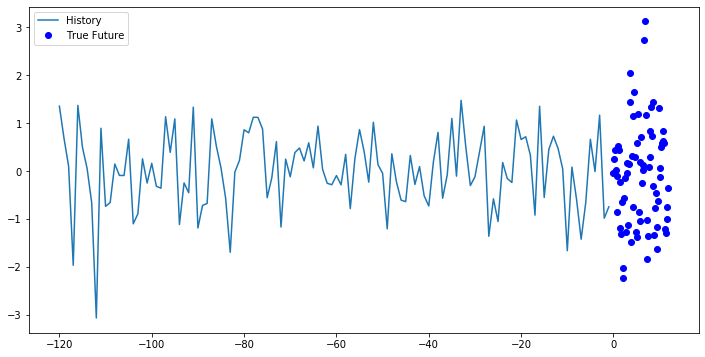

In [69]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [71]:
'''
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape = x_train_single.shape[-2:], return_sequences = True, activation = 'sigmoid'))
single_step_model.add(tf.compat.v2.keras.layers.Dropout(0.3))
single_step_model.add(tf.keras.layers.LSTM(32, return_sequences = True, activation = 'sigmoid'))
single_step_model.add(tf.compat.v2.keras.layers.Dropout(0.3))
single_step_model.add(tf.keras.layers.LSTM(16, activation = 'sigmoid'))
single_step_model.add(tf.keras.layers.Dense(1))
'''

"\nsingle_step_model = tf.keras.models.Sequential()\nsingle_step_model.add(tf.keras.layers.LSTM(32,\n                                           input_shape = x_train_single.shape[-2:], return_sequences = True, activation = 'sigmoid'))\nsingle_step_model.add(tf.compat.v2.keras.layers.Dropout(0.3))\nsingle_step_model.add(tf.keras.layers.LSTM(32, return_sequences = True, activation = 'sigmoid'))\nsingle_step_model.add(tf.compat.v2.keras.layers.Dropout(0.3))\nsingle_step_model.add(tf.keras.layers.LSTM(16, activation = 'sigmoid'))\nsingle_step_model.add(tf.keras.layers.Dense(1))\n"

In [70]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [72]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(1, 72)


In [75]:
a = []
for x, y in val_data_multi.take(1):
    a.append(multi_step_model.predict(x))

In [82]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/30
200/200 [==============================] - 18s 90ms/step - loss: 0.2456 - val_loss: 0.4611
Epoch 2/30
200/200 [==============================] - 15s 73ms/step - loss: 0.0464 - val_loss: 0.4693
Epoch 3/30
200/200 [==============================] - 15s 76ms/step - loss: 0.0363 - val_loss: 0.4750
Epoch 4/30
200/200 [==============================] - 16s 78ms/step - loss: 0.0308 - val_loss: 0.4776
Epoch 5/30
200/200 [==============================] - 16s 78ms/step - loss: 0.0276 - val_loss: 0.4819
Epoch 6/30
200/200 [==============================] - 16s 78ms/step - loss: 0.0245 - val_loss: 0.4832
Epoch 7/30
200/200 [==============================] - 15s 76ms/step - loss: 0.0226 - val_loss: 0.4820
Epoch 8/30
200/200 [==============================] - 15s 77ms/step - loss: 0.0207 - val_loss: 0.4832
Epoch 9/30
200/200 [==============================] - 15s 74ms/step - loss: 0.0196 - val_loss: 0.4825
Epoch 10/30
200/200 [==================

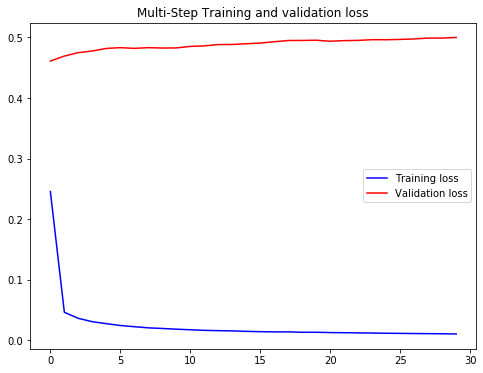

In [83]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')


In [95]:
for x, y in val_data_multi.take(1):
    print(x, '---'* 100, y)

tf.Tensor(
[[[ 1.35408362 -0.41020659 -0.34844686 ... -0.57661449 -0.69049359
    0.20284809]
  [-0.55687268 -0.37032763 -0.6293702  ... -0.40336972 -0.69986869
    0.22102485]
  [ 0.01408378 -0.07550815 -0.07504826 ... -0.20010701 -0.70924379
    0.24256034]
  ...
  [-0.17621513  1.67981174  0.14510424 ... -1.03864516 -0.53934344
    0.78347122]
  [-0.28727931 -0.42166217 -0.34833841 ... -0.99256076 -0.53106486
    0.78611696]
  [-0.07330752  0.49751457  0.20838333 ... -0.90944637 -0.55547986
    0.78289783]]], shape=(1, 120, 98), dtype=float64) ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ tf.Tensor(
[[ 0.2458973   0.92383968  0.97726923  0.34838433 -0.19989254 -0.06648791
   0.41965564  0.34322096  0.64848493  0.61853602  0.29191871

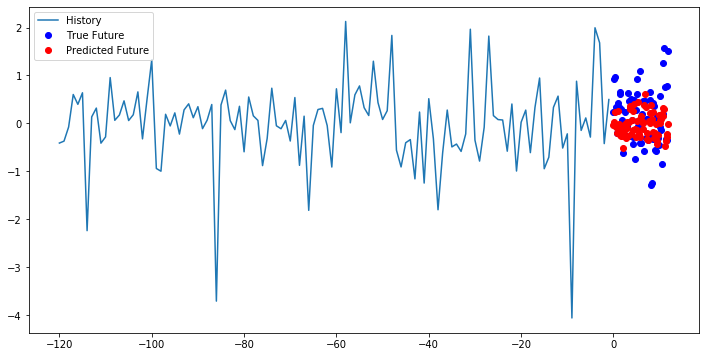

In [97]:
for x, y in val_data_multi.take(1):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [99]:
x= val_data_multi.take(1)

In [102]:
for i in x:
    print(i)

(<tf.Tensor: shape=(1, 120, 98), dtype=float64, numpy=
array([[[ 1.35408362, -0.41020659, -0.34844686, ..., -0.57661449,
         -0.69049359,  0.20284809],
        [-0.55687268, -0.37032763, -0.6293702 , ..., -0.40336972,
         -0.69986869,  0.22102485],
        [ 0.01408378, -0.07550815, -0.07504826, ..., -0.20010701,
         -0.70924379,  0.24256034],
        ...,
        [-0.17621513,  1.67981174,  0.14510424, ..., -1.03864516,
         -0.53934344,  0.78347122],
        [-0.28727931, -0.42166217, -0.34833841, ..., -0.99256076,
         -0.53106486,  0.78611696],
        [-0.07330752,  0.49751457,  0.20838333, ..., -0.90944637,
         -0.55547986,  0.78289783]]])>, <tf.Tensor: shape=(1, 72), dtype=float64, numpy=
array([[ 0.2458973 ,  0.92383968,  0.97726923,  0.34838433, -0.19989254,
        -0.06648791,  0.41965564,  0.34322096,  0.64848493,  0.61853602,
         0.29191871,  0.06644197, -0.04464943, -0.6200459 , -0.02186145,
         0.23374453, -0.00868112, -0.2683788 , -

In [ ]:
# 문제 : val_data_multi에는 어떤 데이터가 들어있는가
# 문제 : take(1)은 어떤 의미인가?
# 문제 : mul